# Drawing graphs in Jupyter

I recently discovered Jupyter's interface for drawing stuff, and at the same time, the `pydot` module. Mixing these two makes it possible to draw beautiful representations of your Python objects. Let's dive through a few examples.

## Using pydot and Jupyter for automatic graph drawing

`pydot` is a Python interface to GraphViz and the related GNU programs, which perform automaticatic graph layout and rendering. The main `pydot` type to deal with is the `Dot` class, which represents a drawable graph. We can create a simple graph like this.

In [15]:
import pydot

In [16]:
graph = pydot.Dot()
graph.add_node(pydot.Node('A'))
graph.add_node(pydot.Node('B'))
graph.add_node(pydot.Node('C'))
graph.add_edge(pydot.Edge('A', 'B'))
graph.add_edge(pydot.Edge('B', 'C'))
graph.add_edge(pydot.Edge('C', 'A'))
graph

The graph is there, it's just that Jupyter doesn't know how to represent it. `pydot` provides several drawing functions. The most interesting in our case is `Dot.create_svg()` which returns a string representing the SVG code necessary to render the graph.

In [17]:
print(graph.create_svg().decode('utf8'))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
<svg width="89pt" height="188pt"
 viewBox="0.00 0.00 89.00 188.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
<g id="graph0" class="graph" transform="scale(1 1) rotate(0) translate(4 184)">
<title>G</title>
<polygon fill="#ffffff" stroke="transparent" points="-4,4 -4,-184 85,-184 85,4 -4,4"/>
<!-- A -->
<g id="node1" class="node">
<title>A</title>
<ellipse fill="none" stroke="#000000" cx="54" cy="-162" rx="27" ry="18"/>
<text text-anchor="middle" x="54" y="-158.3" font-family="Times,serif" font-size="14.00" fill="#000000">A</text>
</g>
<!-- B -->
<g id="node2" class="node">
<title>B</title>
<ellipse fill="none" stroke="#000000" cx="27" cy="-90" rx="27" ry="18"/>
<text text-anchor="middle" x="27" y="-86.3" font

Together with Jupyter's drawing capabilities, we can easily transform this into an *actual* image.

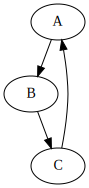

In [18]:
from IPython.display import SVG, display_svg

svg = SVG(graph.create_svg().decode('utf8'))
display_svg(svg)

Now, to put it all together, we can make use of Jupyter's introspection utilities. If you add one of several `_repr_*_` methods in your class, Jupyter will call the appropriate drawing method automagically. In our case, we just need a class that implements `_repr_svg_` and returns the corresponding SVG code. For simplicity, let's make this class inherit `Dot`.

In [19]:
class JupyterDot(pydot.Dot):
    def _repr_svg_(self):
        return self.create_svg().decode('utf8')

If we use `JupyterDot` instead of `Dot` and we repeat the previous code, we get a nice automatic representation behaviour, just as it happens when use lists, dicts, or other native Python classes. We don't need to call Jupyter's drawing method at all!

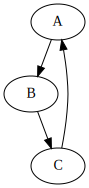

In [20]:
graph = JupyterDot()
graph.add_node(pydot.Node('A'))
graph.add_node(pydot.Node('B'))
graph.add_node(pydot.Node('C'))
graph.add_edge(pydot.Edge('A', 'B'))
graph.add_edge(pydot.Edge('B', 'C'))
graph.add_edge(pydot.Edge('C', 'A'))
graph

Voilá, we just turned `pydot.Dot` into a Jupyter-aware type, simply by adding a one-liner method. Now we can experiment with `pydot` and discover all it's amazing functionalities for creating beautiful graph layouts directly in Jupyter, with real-time, in-browser representation.

## Drawing trees

The simplest and most common use case I always come up across, in which I need graph-drawing funcionality, is drawing trees. `pydot` is great for drawing trees, but it is kind of cumbersome to do all that `pydot.Node(...)` and `pydot.Edge(...)` stuff all the time, if we just want a simple visualization of a tree with a single value in each node. It is easier if we use, say, a `list` to represent the tree structure. A simple recursive method to build the corresponding `JupyterDot` object could be as follows.

In [21]:
def make_tree(tree: list):
    G = JupyterDot()
    _make_tree(tree, G)
    return G
    
def _make_tree(tree: list, G: JupyterDot):
    if not isinstance(tree, list):
        tree = [tree]
        
    root = tree.pop(0)
    root_id = str(len(G.get_node_list()))
    G.add_node(pydot.Node(root_id, label=root, shape='circle'))
    
    for child in tree:
        child = _make_tree(child, G)
        G.add_edge(pydot.Edge(root_id, child))
        
    return root_id

Then we can just call it like this:

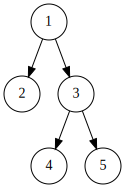

In [22]:
make_tree([1, 2, [3, 4, 5]])

One neat use case is drawing the call tree of recursive methods, in order to understand what's going on with the stack. Arguably the most abussed example to show how recursion works is the *Fibonacci* function, which, as *everyone* knows, and somehow *no one* can help but to repeat everytime (even if it's just to show-off that you know how to write LaTeX), is defined like this:

$$
F(n) = \left\{\begin{array}{ll}
    n & n \in [0,1] \\
    F(n-1) + F(n-2) & n > 1
\end{array}\right.
$$

Here is a simple implementation that computes the *Fibonacci* recursive call tree.

In [23]:
def _fib(n):
    if n == 0:
        return [0]
    if n == 1:
        return [1]
    
    fib0 = _fib(n-1)
    fib1 = _fib(n-2)
    
    return [fib0[0] + fib1[0], fib0, fib1]

def fib(n):
    return make_tree(_fib(n))

This implementation of *Fibonacci* is a well known example of a bad use of recursion, because of the exponential growth in the number of calls with respect to the argument. Here's for $n=6$:

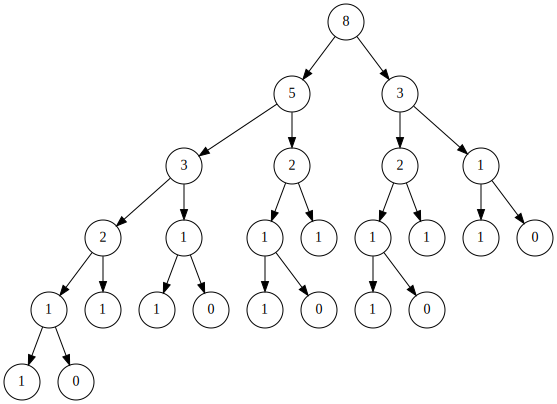

In [24]:
fib(6)

## Automatically drawing recursive methods

The previous example is very nice, because it let's us see how a näive implementation of a recursive method can easily blow up. However, weaving the drawing code into the logic of every method we want to visualize is not a very DRY thing to do (we might say is rather WET: _Whoa, Extremely Tortuous_). This seems like a good time to summon *aspect-oriented programming* and Python's meta-programming utilities (my fancy way to call *decorators*).

The next code is a bit hard to swallow, but I'll try to digest it. The idea is to make a decorator that takes a function, and builds a tree resembling the call stack. Thinking **as the** decorator, we "see" the tree structure when our own `__call__` method get's invoked, because everytime it's invoked, we are inside one recursive call of the wrapped function. However, we do not directly know who called us, because Python provides no such thing as a *caller* attribute. However, we can do some additional bookeeping to simulate the call stack as we are recursively called, and manually maintain our own references to callers. All this is done in the following class, which also contains the code to build the graph representation in a visually nice format.

In [25]:
class draw_call_tree:
    def __init__(self, function):
        self.function = function
        # This is the bookeeping data
        self.stack = []
        self.calls = 0
        
    def __call__(self, *args, **kwargs):
        # Here we are "inside" a recursive call
        call_id = str(self.calls)
        current_node = pydot.Node(call_id, shape='rectangle')

        # Depending if we are the "first" call or not, we have to 
        # create a new graph, or continue the current graph
        if self.stack:
            parent = self.stack[-1]
            self.G.add_node(current_node)
            self.G.add_edge(pydot.Edge(parent, call_id))
        else:
            self.G = JupyterDot()
            self.calls = 0
            self.G.add_node(current_node)
        
        # This is just formatting the input for pretty printing
        args_str = ", ".join(repr(s) for s in args)
        kwargs_str = ", ".join(k + '=' + repr(v) for k,v in kwargs.items())
        
        if not kwargs_str:
            args_final = args_str
        elif not args_str:
            args_final = kwargs_str
        else:
            args_final = args_str + ", " + kwargs_str
        
        # Now the actual (potential) recursion is performed
        self.stack.append(call_id)
        self.calls += 1
        
        try:
            result = self.function(*args, **kwargs)
        except:
            # Yes, I only added this after I got an actual exception.
            self.calls = 0
            self.stack = []
            raise
        
        current_node.set_label(f"{self.function.__name__}({args_final}) = {result}")
        self.stack.pop()
        
        # Now again, if we are "inside" the call tree, we need to behave as if
        # we are the actual function, returning whatever it returns, so that callers up the stack work
        if self.stack:
            return result
        
        # However on the "last" call, we simply return the graph
        self.calls = 0
        return self.G

I hope the comments help. If not, then ignore them. Anyway, here's how we use it to decorate a classic recursive implementation of *Fibonacci*.

In [26]:
@draw_call_tree
def fib(n):
    if n <= 1:
        return n
    
    return fib(n-1) + fib(n-2)

And here's how neat it works.

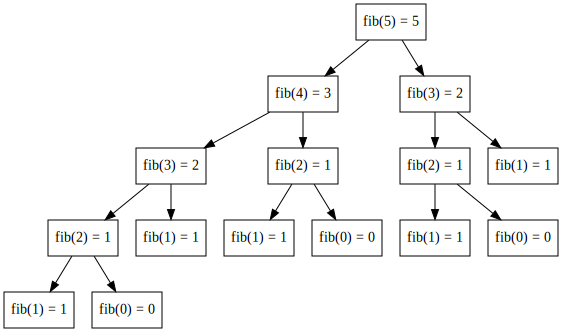

In [27]:
fib(5)

The next step in every single *Fibonacci* explanation ever written, is to introduce *memoization* and show how we can cut down the number of calls by means of a global cache of intermediate results. Probably the simplest (not fastest or smartest) implementation of a memoized _Fibonacci_ is this:

In [28]:
@draw_call_tree
def fib_memo(n, cache={}):
    if n in cache:
        return cache[n]
    
    if n <= 1:
        return n
    
    result = fib_memo(n-1, cache) + fib_memo(n-2, cache)
    cache[n] = result
    return result

Notice how the second time any branch happens to reuse `n`, it is automatically cut and inmediately returns. Also, the visualization of the method arguments shows how the cache is being filled with every call.

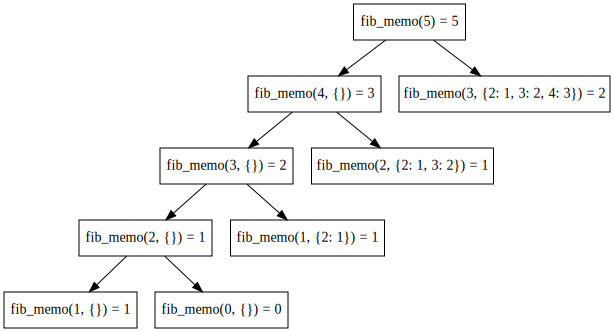

In [29]:
fib_memo(5)

An often overlooked side effect of this implementation is that if you call again, the cache is still there, so it will simply reuse old values.

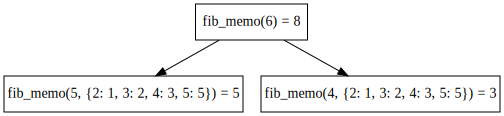

In [30]:
fib_memo(6)

And of course, other recursive methods can be visualized just as easy:

In [31]:
@draw_call_tree
def merge_sort(l):
    # This is NOT an efficient implementation of merge-sort
    # I know it copies a lot of lists, it is only for visualization purposes
    # Knuth, please forgive me, I promise I don't actually code like this in real life
    if len(l) == 1:
        return l
    
    mid = len(l) // 2
    left = l[:mid]
    right = l[mid:]
    
    left = merge_sort(left)
    right = merge_sort(right)
    
    result = []

    while left and right:
        if left[0] <= right[0]:
            result.append(left.pop(0))
        else:
            result.append(right.pop(0))
            
    return result + left + right

I wish I had this when I was learning to program 10 years ago.

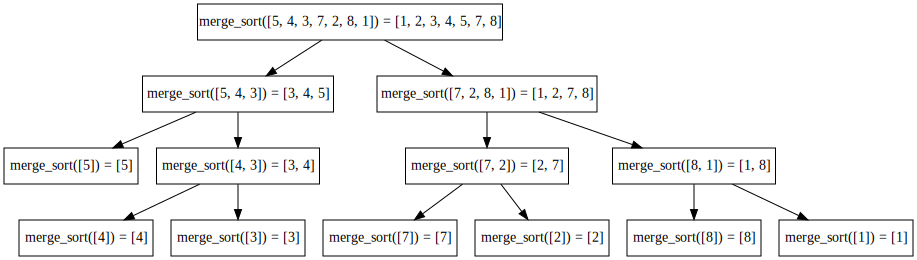

In [32]:
merge_sort([5,4,3,7,2,8,1])

**TODO**: the real deal would be to simultaneously draw different recursive methods that called each other, such as in *Minimax*.

## One final example just to show-off

`pydot` has very nice formatting options. The following example is an `Automaton` class that represents a *NFA* or a *(Non) Deterministic Finite Automaton*, which happens to know how to draw itself.

In [33]:
class Automaton:
    def __init__(self, start, final, states):
        self.start = start
        self.states = states
        self.final = final
        
    def graph(self):
        G = pydot.Dot(rankdir='LR', margin=0.1)
        G.add_node(pydot.Node('start', shape='plaintext', label='', width=0, height=0))
        
        for (start, tran), end in self.states.items():
            G.add_node(pydot.Node(start, shape='circle', style='bold' if start in self.final else ''))
            G.add_node(pydot.Node(end, shape='circle', style='bold' if end in self.final else ''))
            G.add_edge(pydot.Edge(start, end, label=tran, labeldistance=2))
            
        G.add_edge(pydot.Edge('start', self.start, label='', style='dashed'))
        return G
        
    def _repr_svg_(self):
        return self.graph().create_svg().decode('utf8')

As a farewell gift, take this beatufiful (deterministic) automaton (strings over the alphabet $\{0, 1\}$  that represent binary numbers divisible by $3$). If it ring some bells, then maybe we took that same Discrete Math class... Notice that just evaluating the expression triggers the drawing. 

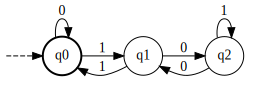

In [34]:
Automaton('q0', ['q0'], {
    ('q0', 0) : 'q0',
    ('q0', 1) : 'q1',
    ('q1', 0) : 'q2',
    ('q1', 1) : 'q0',
    ('q2', 0) : 'q1',
    ('q2', 1) : 'q2',
})